# Using EDHEC Risk Kit Part 3
### Explore use of the library to:
- Explore that Constant Proportion Portfolio Insurance (CPPI) strategy
- Explore how adjusting parameters in CPPI affects floor violations

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
%matplotlib inline

### CPPI strategy:
- Keep exposure in a risky asset for upside potential, while ensuring capital preservation by increasing allocation to a safe asset if your portfolio value is nearing a set floor.

![alt text](http://www.deltaquants.com/assets/images/CPPI.png)

In [2]:
ind_return = erk.get_ind_returns()

# simulate returns from a safer asset, like bonds,
# using geometric brownian motion
safe_r = erk.gbm(
    n_years=10,
    n_scenarios=1,
    mu=0.03,
    sigma=0.015
).pct_change().dropna()

# retrieve telecom returns from 2005 to 2014
# some processing so it runs properly in run_cppi()
risky_r = ind_return.loc['2005':'2014', 'Telcm'].reset_index().drop('index', axis=1)
risky_r.columns = [0]

# CPPI with monthly rebalances
# m = cushion multiplier
backtest = erk.run_cppi(
    risky_r=risky_r,
    safe_r=safe_r,
    m=3,
    start=1000,
    floor=0.8,
)

### Plot performance of CPPI strategy (black) vs strategy of allocating 100% of portfolio to the risky asset (orange)

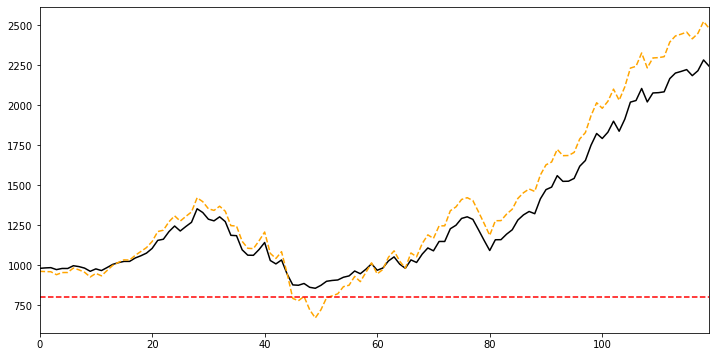

In [3]:
fig, ax = plt.subplots(figsize=(12,6))
backtest['Wealth'].plot(ax=ax, color='k', legend=False)
backtest['Risky Wealth'].plot(ax=ax, color='orange', style='--', legend=False)
ax.axhline(1000*0.8, color='red', linestyle='--')
plt.show()

### Utilize a max drawdown constraints to create a moving floor by incorporting drawdown limits. Set the floor value to 70% of max(peak, account_value)

In [4]:
# with m=3, floor value being 70% of max(peak, account_value),
# max allocation to risky assket is 3*(100-70) = 90%
backtest = erk.run_cppi(
    risky_r=risky_r,
    safe_r=safe_r,
    m=3,
    start=1000,
    riskfree_rate=0.02,
    drawdown=0.3
)

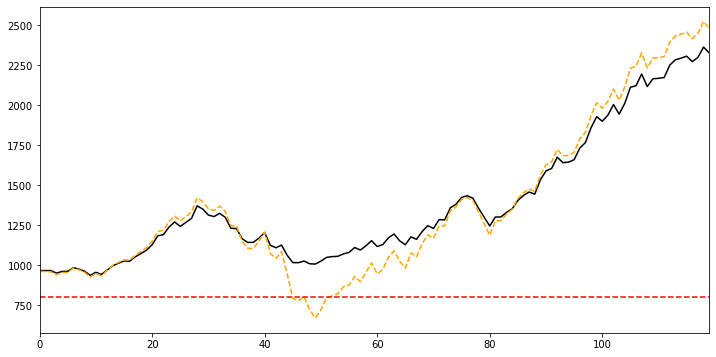

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
backtest['Wealth'].plot(ax=ax, color='k', legend=False)
backtest['Risky Wealth'].plot(ax=ax, color='orange', style='--', legend=False)
ax.axhline(1000*0.8, color='red', linestyle='--')
plt.show()

### Summary of CPPI's returns

In [6]:
erk.summary_stats(backtest['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.092814,0.093399,-0.405699,2.801872,0.039498,0.052413,0.654483,-0.265719


### Summary of 100% Telecom returns

In [7]:
erk.summary_stats(backtest['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.100365,0.156669,-0.879384,4.569815,0.074217,0.108783,0.436942,-0.529317


### CPPI strategy provided much better risk protection
- Max drawdown was halved,
- Negative skewness reduced,
- VaR and CVar near halved
- Higher Sharpe ratio
- Much less fat tail on distribution of monthly returns (kurtosis)

Although, overall, it underperformed because of the run from 2009-2015